<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/Classifiers_with_USE_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/7bf0971e-4d5c-47f4-abc5-4c29d6735f27

In [ ]:
import numpy as np
import pandas as pd
import nltk
import tensorflow_hub as hub
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Load the dataset
df = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
df.shape

(14932, 2)

In [ ]:
class_distribution = df['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


### Cleaning Post

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
df['Question_body_cleaned'] = df['Question_body'].apply(clean_html)


# Print sample cleaned data
print(df[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)

    # Tokenize text
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

# Ensure all values in 'Question_body' are strings and handle NaNs
#df['Question_body_cleaned'] = df['Question_body_cleaned'].fillna('')
#df['Question_body_cleaned'] = df['Question_body_cleaned'].astype(str)
df['Question_body_cleaned'] = df['Question_body_cleaned'].fillna('').astype(str)

# Apply the preprocessing function
df['Question_body_preprocessed'] = df['Question_body_cleaned'].apply(preprocess_text)


## # Save the updated DataFrame to an Excel file

In [ ]:
# Save the updated DataFrame to an Excel file
df.to_excel('Preprocessed_14932_ARPs_and_Programming_Posts.xlsx', index=False)

In [ ]:
# Load Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Embeddings with USE

In [ ]:
# 'The embed_use' function converts preprocessed text into embeddings using the USE model.
#def embed_use(sentences):
    #return use_model([sentences]).numpy().flatten()  # Flatten the embeddings to make it 1D

# Apply the USE embeddings to the Tokens column and save to 'df'
#df['USE_Embeddings'] = df['Question_body_preprocessed'].apply(embed_use)

# Expand the embeddings into separate columns (512 dimensions)
#use_embeddings_df = pd.DataFrame(df['USE_Embeddings'].to_list(), index=df.index)



# Function to convert text into embeddings
def embed_use(sentences):
    return use_model(sentences).numpy()  # No need to flatten for batch processing

# Convert the entire column at once (faster)
sentences = df['Question_body_preprocessed'].dropna().tolist()  # Remove NaNs before processing
embeddings = embed_use(sentences)

# Add embeddings to DataFrame
df = df.loc[df['Question_body_preprocessed'].notna()]  # Keep only valid rows
df['USE_Embeddings'] = list(embeddings)  # Store as a list

# Expand embeddings into separate columns (512 dimensions)
use_embeddings_df = pd.DataFrame(embeddings, index=df.index)


### Save the updated DataFrame with embeddings to an Excel file

In [ ]:
# Save the updated DataFrame with embeddings to an Excel file
use_embeddings_df.to_excel('posts_embeddings.xlsx', index=False)

In [ ]:
# Prepare features and labels
X = np.array(embed_use(df['USE_Embeddings'].tolist()))
y = df['Label'].astype(int).values


In [ ]:
# Prepare features and labels
X = np.vstack(df['USE_Embeddings'].values)  # Stack lists into a 2D array
y = df['Label'].astype(int).values  # Convert labels to int

# Train-test split

In [ ]:
# Split the data, using the specific number of samples for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# NB_USE

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

#nb_model = GaussianNB()
nb_model=GaussianNB(
    priors=None,      # No predefined class priors; computed from the data
    var_smoothing=1e-9 # Small value added to variances for numerical stability
)
nb_model = nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)


# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}, Support: {support_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}, Support: {support_class[1]}')


Overall Accuracy: 0.8985604285236023
Class 0 - Precision: 0.8742928975487115, Recall: 0.9310575635876841, Accuracy: 0.8985604285236023, F1-score: 0.9017828200972448, Support: 1494
Class 1 - Precision: 0.9262177650429799, Recall: 0.8660415271265908, Accuracy: 0.8985604285236023, F1-score: 0.8951194184839044, Support: 1493


## NB Overall Performance

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Train Naive Bayes model
#nb_model = GaussianNB()
nb_model=GaussianNB(
    priors=None,      # No predefined class priors; computed from the data
    var_smoothing=1e-9 # Small value added to variances for numerical stability
)
nb_model = nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Compute overall precision, recall, F1-score using average='binary' (for binary classification)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {accuracy}')

Overall Precision: 0.9262177650429799
Overall Recall: 0.8660415271265908
Overall F1-score: 0.8951194184839044
Overall Accuracy: 0.8985604285236023


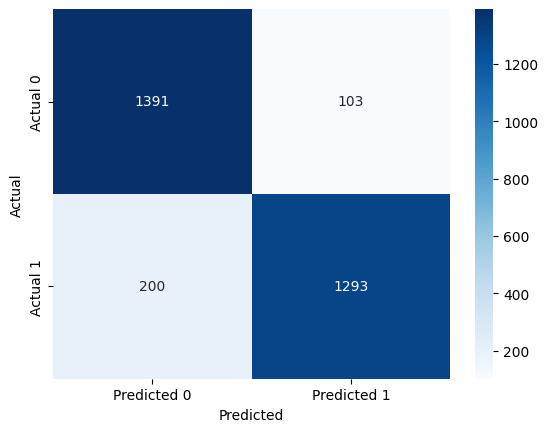

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# kNN_USE

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

#knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model=KNeighborsClassifier(
    n_neighbors=1,      # Number of neighbors to consider (default is 5, but set to 1 in your case)
    weights='uniform',  # All neighbors have equal weight ('distance' would weigh closer neighbors more)
    algorithm='auto',   # Chooses the best algorithm based on data ('ball_tree', 'kd_tree', or 'brute' can be set manually)
    leaf_size=30,       # Affects 'ball_tree' and 'kd_tree' algorithms (ignored for 'brute')
    p=2,                # Power parameter for Minkowski distance (p=2 corresponds to Euclidean distance, p=1 is Manhattan)
    metric='minkowski', # Default distance metric (with p=2, this is Euclidean distance)
    metric_params=None, # No additional parameters for the metric
    n_jobs=None         # No parallel processing (set to -1 to use all CPU cores)
)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)


# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.8767994643454972
Class 0 - Precision: 0.8804054054054054, Recall: 0.8721552878179384, Accuracy: 0.8767994643454972, F1-score: 0.8762609280430397
Class 1 - Precision: 0.8732581287325812, Recall: 0.8814467515070328, Accuracy: 0.8767994643454972, F1-score: 0.8773333333333333


## Overall

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train KNeighbors model
#knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model=KNeighborsClassifier(
    n_neighbors=1,      # Number of neighbors to consider (default is 5, but set to 1 in your case)
    weights='uniform',  # All neighbors have equal weight ('distance' would weigh closer neighbors more)
    algorithm='auto',   # Chooses the best algorithm based on data ('ball_tree', 'kd_tree', or 'brute' can be set manually)
    leaf_size=30,       # Affects 'ball_tree' and 'kd_tree' algorithms (ignored for 'brute')
    p=2,                # Power parameter for Minkowski distance (p=2 corresponds to Euclidean distance, p=1 is Manhattan)
    metric='minkowski', # Default distance metric (with p=2, this is Euclidean distance)
    metric_params=None, # No additional parameters for the metric
    n_jobs=None         # No parallel processing (set to -1 to use all CPU cores)
)

knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Compute overall precision, recall, and F1-score using average='binary' for binary classification
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {accuracy}')

Overall Precision: 0.8732581287325812
Overall Recall: 0.8814467515070328
Overall F1-score: 0.8773333333333333
Overall Accuracy: 0.8767994643454972


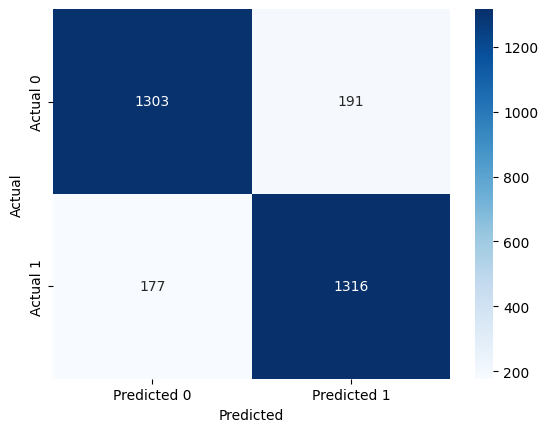

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# DT_USE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
#dt_model = DecisionTreeClassifier()
dt_model=DecisionTreeClassifier(
    criterion='gini',          # Splitting criterion ('gini' for Gini impurity, or 'entropy' for information gain)
    splitter='best',           # Chooses the best split at each node ('random' selects a random split)
    max_depth=None,            # No depth limit (tree grows until all leaves are pure or min_samples_split is reached)
    min_samples_split=2,       # Minimum samples required to split an internal node
    min_samples_leaf=1,        # Minimum samples required to be a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of total samples required in a leaf node
    max_features=None,         # No limit on the number of features considered for the best split
    random_state=None,         # No fixed randomness by default
    max_leaf_nodes=None,       # No limit on the number of leaf nodes
    min_impurity_decrease=0.0, # A node splits if it decreases impurity by at least this amount
    class_weight=None,         # No class weighting by default
    ccp_alpha=0.0              # Complexity parameter for pruning (0 means no pruning)
)
dt_model = dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)



# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.8155339805825242
Class 0 - Precision: 0.8196610169491525, Recall: 0.8092369477911646, Accuracy: 0.8155339805825242, F1-score: 0.8144156281576288
Class 1 - Precision: 0.8115079365079365, Recall: 0.8218352310783658, Accuracy: 0.8155339805825242, F1-score: 0.8166389351081531


## Overall

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train DecisionTree model
#dt_model = DecisionTreeClassifier()
dt_model=DecisionTreeClassifier(
    criterion='gini',          # Splitting criterion ('gini' for Gini impurity, or 'entropy' for information gain)
    splitter='best',           # Chooses the best split at each node ('random' selects a random split)
    max_depth=None,            # No depth limit (tree grows until all leaves are pure or min_samples_split is reached)
    min_samples_split=2,       # Minimum samples required to split an internal node
    min_samples_leaf=1,        # Minimum samples required to be a leaf node
    min_weight_fraction_leaf=0.0, # Minimum weighted fraction of total samples required in a leaf node
    max_features=None,         # No limit on the number of features considered for the best split
    random_state=None,         # No fixed randomness by default
    max_leaf_nodes=None,       # No limit on the number of leaf nodes
    min_impurity_decrease=0.0, # A node splits if it decreases impurity by at least this amount
    class_weight=None,         # No class weighting by default
    ccp_alpha=0.0              # Complexity parameter for pruning (0 means no pruning)
)
dt_model = dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Compute overall precision, recall, and F1-score using average='binary' for binary classification
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {accuracy}')

Overall Precision: 0.8170068027210884
Overall Recall: 0.8044206296048225
Overall F1-score: 0.8106648666891664
Overall Accuracy: 0.8121861399397389


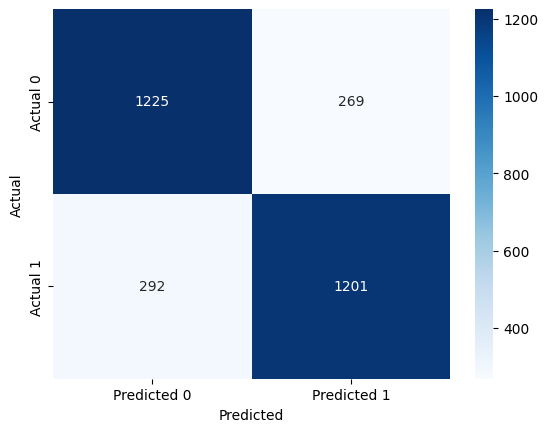

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# LG_USE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
#lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model=LogisticRegression(
    penalty='l2',      # Default is L2 regularization (Ridge)
    dual=False,        # Dual formulation is only used when `penalty='l2'` and the number of samples > number of features
    tol=1e-4,          # Tolerance for stopping criteria
    C=1.0,             # Inverse of regularization strength (1.0 means moderate regularization)
    fit_intercept=True,# Whether to include an intercept term
    intercept_scaling=1, # Only relevant for `solver='liblinear'`
    class_weight=None, # No class weighting by default
    random_state=None, # No fixed randomness
    solver='lbfgs',    # Default solver (good for most cases, but does not support `l1` penalty)
    max_iter=100,      # Maximum number of iterations for convergence
    multi_class='auto',# Automatically chooses between 'ovr' (one-vs-rest) and 'multinomial'
    verbose=0,         # No verbosity (silent mode)
    warm_start=False,  # Whether to reuse previous solution for faster convergence
    n_jobs=None,       # No parallelization (only relevant for solvers like 'saga' or 'lbfgs')
    l1_ratio=None      # Only used if `penalty='elasticnet'`
)
lg_model = lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)



# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.9233344492802142
Class 0 - Precision: 0.9147540983606557, Recall: 0.9337349397590361, Accuracy: 0.9233344492802142, F1-score: 0.9241470685657502
Class 1 - Precision: 0.9322845417236663, Recall: 0.9129269926322839, Accuracy: 0.9233344492802142, F1-score: 0.9225042301184433


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Overall

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train Logistic Regression model
#lg_model = LogisticRegression(C=5, penalty='l1', solver='liblinear')
lg_model=LogisticRegression(
    penalty='l2',      # Default is L2 regularization (Ridge)
    dual=False,        # Dual formulation is only used when `penalty='l2'` and the number of samples > number of features
    tol=1e-4,          # Tolerance for stopping criteria
    C=1.0,             # Inverse of regularization strength (1.0 means moderate regularization)
    fit_intercept=True,# Whether to include an intercept term
    intercept_scaling=1, # Only relevant for `solver='liblinear'`
    class_weight=None, # No class weighting by default
    random_state=None, # No fixed randomness
    solver='lbfgs',    # Default solver (good for most cases, but does not support `l1` penalty)
    max_iter=100,      # Maximum number of iterations for convergence
    multi_class='auto',# Automatically chooses between 'ovr' (one-vs-rest) and 'multinomial'
    verbose=0,         # No verbosity (silent mode)
    warm_start=False,  # Whether to reuse previous solution for faster convergence
    n_jobs=None,       # No parallelization (only relevant for solvers like 'saga' or 'lbfgs')
    l1_ratio=None      # Only used if `penalty='elasticnet'`
)
lg_model = lg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lg_model.predict(X_test)

# Compute overall precision, recall, and F1-score using average='binary' for binary classification
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')

Overall Precision: 0.9322845417236663
Overall Recall: 0.9129269926322839
Overall F1-score: 0.9225042301184433
Overall Accuracy: 0.9233344492802142


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


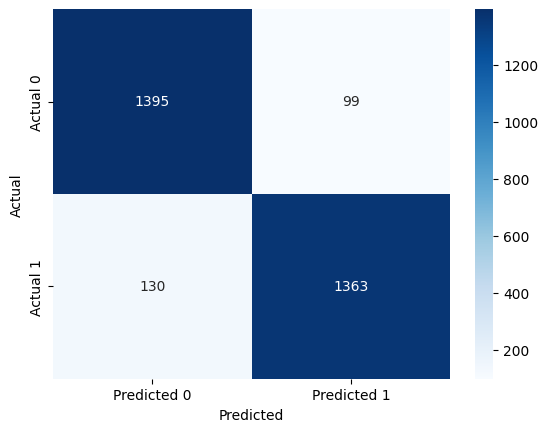

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM_USE

In [ ]:
# Train the SVM model using the sentence embeddings
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.svm import LinearSVC
#svm_model = LinearSVC()
svm_model =LinearSVC(
    penalty='l2',       # Uses L2 regularization by default
    loss='squared_hinge', # Loss function (squared hinge loss for better optimization)
    dual=True,          # Uses dual formulation when n_samples > n_features
    tol=1e-4,           # Tolerance for stopping criteria
    C=1.0,              # Regularization strength (inverse of lambda)
    multi_class='ovr',  # One-vs-Rest (OvR) for multi-class classification
    fit_intercept=True, # Includes an intercept term
    intercept_scaling=1,# Scaling factor for intercept (only when fit_intercept=True)
    class_weight=None,  # No class weighting by default
    verbose=0,          # No logging output
    random_state=None,  # No fixed randomness
    max_iter=1000       # Maximum number of iterations for convergence
)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)


# Compute metrics for each class
precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Extract TP, TN, FP, FN for each class
TP_0, FN_0 = conf_matrix[0, 0], conf_matrix[0, 1]
FP_0, TN_0 = conf_matrix[1, 0], conf_matrix[1, 1]

TP_1, FN_1 = conf_matrix[1, 1], conf_matrix[1, 0]
FP_1, TN_1 = conf_matrix[0, 1], conf_matrix[0, 0]

# Calculate accuracy for each class
accuracy_class_0 = (TP_0 + TN_0) / (TP_0 + TN_0 + FP_0 + FN_0)
accuracy_class_1 = (TP_1 + TN_1) / (TP_1 + TN_1 + FP_1 + FN_1)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

print(f'Overall Accuracy: {overall_accuracy}')

print(f'Class 0 - Precision: {precision_class[0]}, Recall: {recall_class[0]}, Accuracy: {accuracy_class_0}, F1-score: {f1_class[0]}')
print(f'Class 1 - Precision: {precision_class[1]}, Recall: {recall_class[1]}, Accuracy: {accuracy_class_1}, F1-score: {f1_class[1]}')


Overall Accuracy: 0.9253431536658855
Class 0 - Precision: 0.9167213114754098, Recall: 0.9357429718875502, Accuracy: 0.9253431536658855, F1-score: 0.9261344816164293
Class 1 - Precision: 0.9343365253077975, Recall: 0.9149363697253852, Accuracy: 0.9253431536658855, F1-score: 0.9245346869712352


## Overall

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Train the SVM model using the sentence embeddings
#svm_model = LinearSVC()
svm_model =LinearSVC(
    penalty='l2',       # Uses L2 regularization by default
    loss='squared_hinge', # Loss function (squared hinge loss for better optimization)
    dual=True,          # Uses dual formulation when n_samples > n_features
    tol=1e-4,           # Tolerance for stopping criteria
    C=1.0,              # Regularization strength (inverse of lambda)
    multi_class='ovr',  # One-vs-Rest (OvR) for multi-class classification
    fit_intercept=True, # Includes an intercept term
    intercept_scaling=1,# Scaling factor for intercept (only when fit_intercept=True)
    class_weight=None,  # No class weighting by default
    verbose=0,          # No logging output
    random_state=None,  # No fixed randomness
    max_iter=1000       # Maximum number of iterations for convergence
)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)

# Compute overall precision, recall, and F1-score using average='binary' for binary classification
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Print overall metrics
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')

Overall Precision: 0.9343365253077975
Overall Recall: 0.9149363697253852
Overall F1-score: 0.9245346869712352
Overall Accuracy: 0.9253431536658855


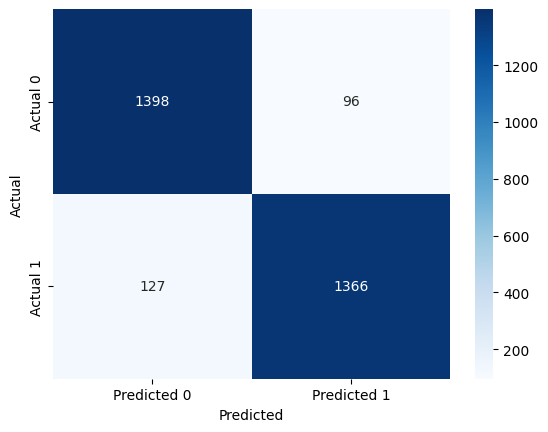

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()